In [45]:
from __future__ import division

import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

import torch
import torchvision.utils as vutils
from scipy.io import loadmat, savemat
import numpy as np
import argparse
from torch.autograd import Variable

from loaders import locations, getLoaders
from models import getModels
from scipy.stats import kendalltau # distance metrics between permutations


def extractPercentileStats(trainProbs, testProbs):
    sortedInds = np.argsort(np.concatenate([trainProbs, testProbs]))
    trainTest = np.concatenate([np.ones(len(trainProbs), dtype='int'),np.zeros(len(testProbs),dtype='int')])
    trainTest = trainTest[sortedInds]
    cumulative = np.cumsum(trainTest)
    testPercentiles = cumulative[trainTest==0]/float(len(trainProbs))
    return testPercentiles

def heatmapFlowgan(net, codesOnly=False):
    grid0, grid1 = np.meshgrid(np.linspace(-1.5,1.5,100),np.linspace(1.5,-1.5,100))
    print grid0.shape, grid1.shape
    pts = np.zeros((10000,2))
    for i in range(100):
        for j in range(100):
            pts[i*100+j,:] = grid0[i,j],grid1[i,j]
    ptsTorch = Variable(torch.from_numpy(pts.astype(np.float32)))
    vals, logp = net.invert(ptsTorch)
    
    if codesOnly:
        vals = vals.data.numpy()
        logpcodes = -0.5*np.sum(vals*vals,1)
        logpcodes = logpcodes.squeeze()
    #    if compareProbs:
        logpmodel = logp.data.numpy().squeeze()
        jacob = logpmodel-logpcodes
        print jacob.min(), jacob.max(), jacob.mean()
        plt.figure()
        plt.hist(jacob)
        plt.figure()
        plt.hist(logpcodes[logpcodes>-100])
        inds1 = np.argsort(logpcodes)
        inds2 = np.argsort(logpmodel)
        print np.sum(inds1==inds2)
        print kendalltau(inds1, inds2)
            
        sortedModel = logpmodel[inds1]
        plt.figure()
        plt.plot(sortedModel, '.')
            
        probsNumpyCodes = logpcodes.reshape((100,100))
        
              #  print probsNumpy[:5,:5]
        transformedCodes = np.exp(probsNumpyCodes)
           # transformed = probsNumpy[probsNumpy<probsNumpy.mean()]=probsNumpy.mean()
        plt.figure()
        plt.imshow(transformedCodes)
        
        probsNumpy = logpmodel.reshape((100,100))
        transformed = np.exp(probsNumpy)
        plt.figure()
        plt.imshow(transformed)

            
    else:
        probsNumpy = logp.data.numpy().reshape((100,100))
        
          #  print probsNumpy[:5,:5]
        transformed = np.exp(probsNumpy)
           # transformed = probsNumpy[probsNumpy<probsNumpy.mean()]=probsNumpy.mean()
        plt.figure()
        plt.imshow(transformed)
    
def plotMogSamplesFlowgan(netG, npts):
    samples = np.random.normal(0,1,(npts,2)).astype(np.float32)
    samples = Variable(torch.from_numpy(samples))
    pts, _ = netG(samples)
    pts = pts.data.numpy()
    plt.figure()
    plt.plot(pts[:,0], pts[:,1], '.')
    
def plotMogSamples(netG, npts):
    samples = np.random.normal(0,1,(npts,2)).astype(np.float32)
    samples = Variable(torch.from_numpy(samples))
    pts = netG(samples).data.numpy()
    plt.plot(pts[:,0], pts[:,1], '.')
    
def hiLow(pdict, number=64, imageArray=None, nrow=8, classes=None):
    if imageArray is None:
        ims = pdict['images']
    else:
        ims = imageArray
        
    probs = pdict['probs'].squeeze()
    
    
    if classes is not None:
        unique = np.unique(classes)
        for v in unique:
            inds = np.argsort(probs[classes==v])
            imsRestricted = ims[classes==v]
            
            classInds = np.where((classes==v)[inds])[0]
           # print classes[classInds]
            imsTop = torch.from_numpy(imsRestricted[inds[-number:]])
            imsBot = torch.from_numpy(imsRestricted[inds[:number]])
            topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
            botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)
            print "Class", v
            plt.figure(figsize=(5,5))
            plt.imshow(topGrid.numpy().transpose((1,2,0)))
            plt.figure(figsize=(5,5))
            plt.imshow(botGrid.numpy().transpose((1,2,0)))
    else:
        inds = np.argsort(probs)
        imsTop = torch.from_numpy(ims[inds[-number:]])
        imsBot = torch.from_numpy(ims[inds[:number]])

        topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
        botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)

        #if hi:
        plt.figure(figsize=(15,15))
        plt.imshow(topGrid.numpy().transpose((1,2,0)))
        #else:
        plt.figure(figsize=(15,15))
        plt.imshow(botGrid.numpy().transpose((1,2,0)))
    
    

def percentiles():
    pass


(100, 100) (100, 100)
-0.7466736 3.4527664 1.4519408
455
KendalltauResult(correlation=0.0865983798379838, pvalue=1.4408608796086082e-38)


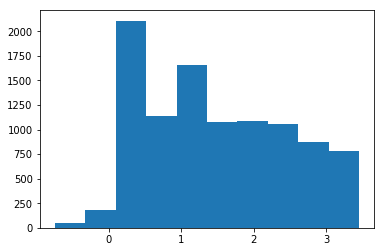

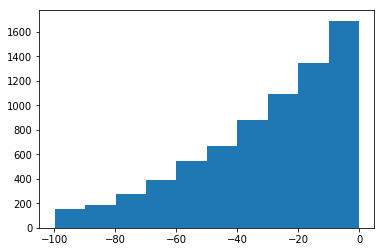

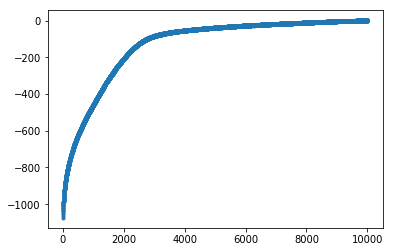

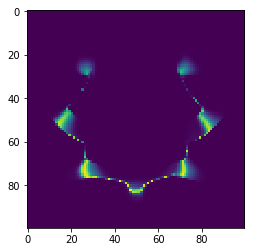

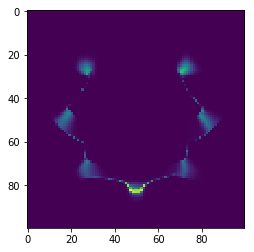

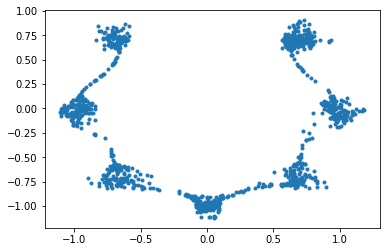

In [46]:
# View heatmap for FlowGAN mixture of gaussians trained on 7 means
net = getModels('mogNVP')[0]
net.load_state_dict(torch.load('generated/final/mog_flowgan_seven/netG_10.pth', lambda s,t:s))
heatmapFlowgan(net, codesOnly=True)
plotMogSamplesFlowgan(net, 1000)

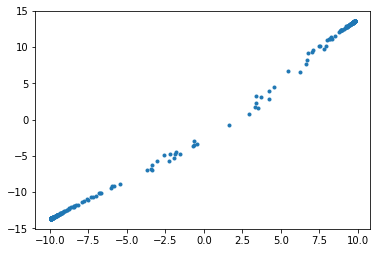

In [8]:
# Sampled points for regular mog-GAN mixture of gaussians trained on 7 means
# This simply doesn't work, no matter what I try
# Will not use these results
# beta1 = 0.9, mog_sohil
# This is like Sohil's results
# Neither sohil gan nor infogan worked
# BiGAN probably works, but etc....
net = getModels('mogInfogan')[0]
net.load_state_dict(torch.load('generated/final/mog_infogan/netG_10.pth', lambda s,t:s))
#heatmap(net)
plotMogSamples(net, 1000)